# Описание проекта

В данном проекте у нас есть данные 500 пользователей телеком-оператора "Мегалайн" (звонки, смс, интернет). Наша цель состоит в том, чтобы используя эти данные, понять какой тариф лучше: Смарт или Ультра. Это поможет спланировать рекламный бюджет.

Сперва изучим данные, затем подготовим их для анализа (приведем переменные к нужным типам, рассчитаем помесячные показатели на пользователя), проведем исследовательский анализ данных, и применим статистический тест для проверки интересующих нас гипотез.

## Изучение данных

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import random as rd

Считаем данные. При считывании сразу переведем колонки с датами в тип ***datetime*** с помощью параметра **parse_dates**.

In [25]:
try:
    calls = pd.read_csv('/datasets/calls.csv', parse_dates=['call_date'])
    internet = pd.read_csv('/datasets/internet.csv', parse_dates=['session_date'])
    messages = pd.read_csv('/datasets/messages.csv', parse_dates=['message_date'])
    tariffs = pd.read_csv('/datasets/tariffs.csv')
    users = pd.read_csv('/datasets/users.csv', parse_dates=['reg_date'], index_col=['user_id'])
except:
    calls = pd.read_csv('/home/uladzislau/Documents/Yandex DS/Projects/Stat analysis/calls.csv', parse_dates=['call_date'])
    internet = pd.read_csv('/home/uladzislau/Documents/Yandex DS/Projects/Stat analysis/internet.csv', parse_dates=['session_date'])
    messages = pd.read_csv('/home/uladzislau/Documents/Yandex DS/Projects/Stat analysis/messages.csv', parse_dates=['message_date'])
    tariffs = pd.read_csv('/home/uladzislau/Documents/Yandex DS/Projects/Stat analysis/tariffs.csv')
    users = pd.read_csv('/home/uladzislau/Documents/Yandex DS/Projects/Stat analysis/users.csv', parse_dates=['reg_date'], index_col=['user_id'])

In [26]:
# изучим основную информацию по датасетам через цикл
dfs = [calls, internet, messages, tariffs, users]
for df in dfs:
    print(df.info())
    print()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null datetime64[ns]
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 6.2+ MB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null datetime64[ns]
user_id         149396 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 5.7+ MB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null datetime64[ns]
user_id         123036 non-null int64
dtypes: datetime64

In [27]:
# выведем на экран сами датасеты для изучения
for df in dfs:
    display(df)
    print()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
...,...,...,...,...
202602,1499_215,2018-12-26,0.76,1499
202603,1499_216,2018-10-18,18.83,1499
202604,1499_217,2018-11-10,10.81,1499
202605,1499_218,2018-10-06,4.27,1499


,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000
...,...,...,...,...,...
149391,149391,1499_152,318.90,2018-10-03,1499
149392,149392,1499_153,490.13,2018-12-14,1499
149393,149393,1499_154,0.00,2018-10-27,1499
149394,149394,1499_155,1246.32,2018-11-26,1499


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
...,...,...,...
123031,1499_179,2018-12-12,1499
123032,1499_180,2018-09-28,1499
123033,1499_181,2018-09-27,1499
123034,1499_182,2018-11-15,1499


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


,age,churn_date,city,first_name,last_name,reg_date,tariff
user_id,,,,,,,
1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
...,...,...,...,...,...,...,...
1495,65,NaN,Иркутск,Авксентий,Фокин,2018-08-28,ultra
1496,36,NaN,Вологда,Трифон,Блохин,2018-01-27,smart
1497,32,NaN,Челябинск,Каролина,Агеева,2018-10-09,smart


In [28]:
# удалим ненужную колонку с id в датасете internet
internet.drop('Unnamed: 0', axis=1, inplace=True)
internet

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000
...,...,...,...,...
149391,1499_152,318.90,2018-10-03,1499
149392,1499_153,490.13,2018-12-14,1499
149393,1499_154,0.00,2018-10-27,1499
149394,1499_155,1246.32,2018-11-26,1499


In [29]:
# выведем описательную статистику по датасетам через цикл
for df in dfs:
    display(df.describe())

,duration,user_id
count,202607.000000,202607.000000
mean,6.755887,1253.940619
std,5.843365,144.722751
min,0.000000,1000.000000
25%,1.300000,1126.000000
50%,6.000000,1260.000000
75%,10.700000,1379.000000
max,38.000000,1499.000000


,mb_used,user_id
count,149396.000000,149396.000000
mean,370.192426,1252.099842
std,278.300951,144.050823
min,0.000000,1000.000000
25%,138.187500,1130.000000
50%,348.015000,1251.000000
75%,559.552500,1380.000000
max,1724.830000,1499.000000


,user_id
count,123036.000000
mean,1256.989410
std,143.523967
min,1000.000000
25%,1134.000000
50%,1271.000000
75%,1381.000000
max,1499.000000


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
count,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
mean,525.000000,23040.000000,1750.000000,1250.000000,175.000000,2.000000,2.000000
std,671.751442,10861.160159,1767.766953,989.949494,35.355339,1.414214,1.414214
min,50.000000,15360.000000,500.000000,550.000000,150.000000,1.000000,1.000000
25%,287.500000,19200.000000,1125.000000,900.000000,162.500000,1.500000,1.500000
50%,525.000000,23040.000000,1750.000000,1250.000000,175.000000,2.000000,2.000000
75%,762.500000,26880.000000,2375.000000,1600.000000,187.500000,2.500000,2.500000
max,1000.000000,30720.000000,3000.000000,1950.000000,200.000000,3.000000,3.000000


,age
count,500.00000
mean,46.58800
std,16.66763
min,18.00000
25%,32.00000
50%,46.00000
75%,62.00000
max,75.00000


### Вывод

Данные содержат переменные разных типов (даты, строки, числа). Все колонки, содержащие даты, перевели в соответствующий формат при считывании данных. Колонку, содержащую длительность звонков в датасете **calls** неоходимо округлить до целых минут (в соответствии с правилами оператора) для каждого наблюдения и перевести в тип ***int***.

Описательная статистика не выявила аномалий в данных.

Пропуски есть только в в колонке **churn_date** датасета **users**. Они обозначают, что тариф действовал на момент выгрузки данных. Можно заменить их значениями-заглушками или не трогать вообще.

## Подготовка данных

### Изменение типа переменных

Необходимо округлить минуты звонков в соответствии с правилами оператора и перевести их в тип ***int***.

In [31]:
#---------------OLD CODE---------------#
# округлим продолжительность звонков до целых и переведем в int
#calls['duration'] = round(calls['duration'], 0).astype('int')
#calls.info()

#---------------NEW CODE---------------#
# округлим продолжительность звонков до целых и переведем в int
calls['duration'] = np.ceil(calls['duration']).astype('int')
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null datetime64[ns]
duration     202607 non-null int64
user_id      202607 non-null int64
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 6.2+ MB


### Расчет помесячных показателей на пользователя

Посчитаем количество звонков и их продолжительность, количесвто смс, и количество интернет траффика для каждого пользователя помесячно.

In [33]:
# количество звонков в месяц на пользователя
calls['month'] = calls['call_date'].dt.month
calls_month = calls.pivot_table(index=['user_id', 'month'], values='duration', aggfunc=['count', 'sum']).reset_index()
calls_month.columns = ['user_id', 'month', 'n_calls', 'calls_duration']
calls_month

,user_id,month,n_calls,calls_duration
0,1000,5,22,159
1,1000,6,43,172
2,1000,7,47,340
3,1000,8,52,408
4,1000,9,58,466
...,...,...,...,...
3169,1498,10,41,247
3170,1499,9,9,70
3171,1499,10,68,449
3172,1499,11,74,612


In [34]:
messages['month'] = messages['message_date'].dt.month
messages_month = messages.pivot_table(index=['user_id', 'month'], values='id', aggfunc='count').reset_index()
messages_month.columns = ['user_id', 'month', 'n_messages']
messages_month

,user_id,month,n_messages
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57
...,...,...,...
2712,1498,10,42
2713,1499,9,11
2714,1499,10,48
2715,1499,11,59


In [35]:
internet['month'] = internet['session_date'].dt.month
internet_month = internet.pivot_table(index=['user_id', 'month'], values='mb_used', aggfunc='sum').reset_index()
internet_month

,user_id,month,mb_used
0,1000,5,2253.49
1,1000,6,23233.77
2,1000,7,14003.64
3,1000,8,14055.93
4,1000,9,14568.91
...,...,...,...
3198,1498,10,20579.36
3199,1499,9,1845.75
3200,1499,10,17788.51
3201,1499,11,17963.31


Объединим сводные таблицы в одну и добавим тариф пользователя. В итоге, таблица должна иметь id пользователя, месяц пользования, количество звонков в месяце, продолжительность звонков в месяце, количество сообщений в месяце, количество интернет-траффика в месяце, и тариф пользователя.

In [36]:
internet_month

,user_id,month,mb_used
0,1000,5,2253.49
1,1000,6,23233.77
2,1000,7,14003.64
3,1000,8,14055.93
4,1000,9,14568.91
...,...,...,...
3198,1498,10,20579.36
3199,1499,9,1845.75
3200,1499,10,17788.51
3201,1499,11,17963.31


In [37]:
users_activity_month = (internet_month.merge(calls_month, on=['user_id', 'month'], how='left').
 merge(messages_month, on=['user_id', 'month'], how='left').
 merge(users['tariff'], on='user_id')
)

In [38]:
users_activity_month

,user_id,month,mb_used,n_calls,calls_duration,n_messages,tariff
0,1000,5,2253.49,22.0,159.0,22.0,ultra
1,1000,6,23233.77,43.0,172.0,60.0,ultra
2,1000,7,14003.64,47.0,340.0,75.0,ultra
3,1000,8,14055.93,52.0,408.0,81.0,ultra
4,1000,9,14568.91,58.0,466.0,57.0,ultra
...,...,...,...,...,...,...,...
3198,1498,10,20579.36,41.0,247.0,42.0,smart
3199,1499,9,1845.75,9.0,70.0,11.0,smart
3200,1499,10,17788.51,68.0,449.0,48.0,smart
3201,1499,11,17963.31,74.0,612.0,59.0,smart


In [39]:
# проверим пропуски
users_activity_month.isna().sum()

user_id             0
month               0
mb_used             0
n_calls            40
calls_duration     40
n_messages        497
tariff              0
dtype: int64

Некоторые пользователи не использовали интернет, не звонили и не отправляли сообщения в какие-то из месяцев. Заменим эти пропуски на 0.

In [40]:
users_activity_month.fillna(0, inplace=True)

Посчитаем помесячную выручку на пользователя.

In [41]:
def month_revenue(row):
    if row['tariff'] == 'smart':
        min_left_smart = row['calls_duration'] - int(tariffs.query('tariff_name == "smart"')['minutes_included'])
        messages_left_smart = row['n_messages'] - int(tariffs.query('tariff_name == "smart"')['messages_included'])
        internet_left_smart = row['mb_used'] - int(tariffs.query('tariff_name == "smart"')['mb_per_month_included'])
        
        if min_left_smart < 0:
            min_left_smart = 0
        if messages_left_smart < 0:
            messages_left_smart = 0
        if internet_left_smart < 0:
            internet_left_smart = 0
        
        return ((min_left_smart * int(tariffs.query('tariff_name == "smart"')['rub_per_minute'])) +
                 (messages_left_smart * int(tariffs.query('tariff_name == "smart"')['rub_per_message'])) +
                 ((np.ceil(internet_left_smart / 1024)) * int(tariffs.query('tariff_name == "smart"')['rub_per_gb'])) +
                 (int(tariffs.query('tariff_name == "smart"')['rub_monthly_fee']))
               )
        
    else:
        min_left_ultra = row['calls_duration'] - int(tariffs.query('tariff_name == "ultra"')['minutes_included'])
        messages_left_ultra = row['n_messages'] - int(tariffs.query('tariff_name == "ultra"')['messages_included'])
        internet_left_ultra = row['mb_used'] - int(tariffs.query('tariff_name == "ultra"')['mb_per_month_included'])
        
        if min_left_ultra < 0:
            min_left_ultra = 0
        if messages_left_ultra < 0:
            messages_left_ultra = 0
        if internet_left_ultra < 0:
            internet_left_ultra = 0
        
        return ((min_left_ultra * int(tariffs.query('tariff_name == "ultra"')['rub_per_minute'])) +
                 (messages_left_ultra * int(tariffs.query('tariff_name == "ultra"')['rub_per_message'])) +
                 ((np.ceil(internet_left_ultra / 1024)) * int(tariffs.query('tariff_name == "ultra"')['rub_per_gb'])) +
                 (int(tariffs.query('tariff_name == "ultra"')['rub_monthly_fee']))
               )        

In [42]:
users_activity_month['revenue'] = users_activity_month.apply(month_revenue, axis=1)
users_activity_month

,user_id,month,mb_used,n_calls,calls_duration,n_messages,tariff,revenue
0,1000,5,2253.49,22.0,159.0,22.0,ultra,1950.0
1,1000,6,23233.77,43.0,172.0,60.0,ultra,1950.0
2,1000,7,14003.64,47.0,340.0,75.0,ultra,1950.0
3,1000,8,14055.93,52.0,408.0,81.0,ultra,1950.0
4,1000,9,14568.91,58.0,466.0,57.0,ultra,1950.0
...,...,...,...,...,...,...,...,...
3198,1498,10,20579.36,41.0,247.0,42.0,smart,1750.0
3199,1499,9,1845.75,9.0,70.0,11.0,smart,550.0
3200,1499,10,17788.51,68.0,449.0,48.0,smart,1150.0
3201,1499,11,17963.31,74.0,612.0,59.0,smart,1513.0


## Исследование данных

Рассчитаем среднее, дисперсию, и стандартное отклонение для времени звонков, количества смс, использованного интернета помесячной выручки в зависимости от тарифного плана.

In [18]:
users_statistics = round(users_activity_month.pivot_table(index='tariff',
                                                   values=['calls_duration', 'n_messages',
                                                          'mb_used', 'revenue'],
                                                   aggfunc=['mean', 'var', 'std']
                        ),2)
users_statistics

mean                                          var  \
       calls_duration   mb_used n_messages  revenue calls_duration   
tariff                                                               
smart          394.42  16215.66      33.40  1257.28       32321.48   
ultra          499.87  19668.49      49.59  2071.38       89818.49   

                                                     std                      \
            mb_used n_messages    revenue calls_duration  mb_used n_messages   
tariff                                                                         
smart   34359951.68     796.70  641082.73         179.78  5861.74      28.23   
ultra   98864248.95    2301.92  142819.95         299.70  9943.05      47.98   

                
       revenue  
tariff          
smart   800.68  
ultra   377.92

Построим гистограммы для времени звонков, количества смс и использованного интернета в зависимости от тарифного плана.

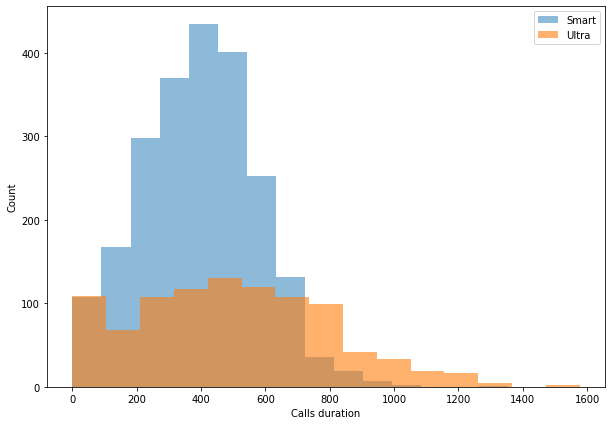

In [19]:
# гистограммы продолжительности звонков

# перенесем данные для разных тарифов в разные датафрэймы
smart = users_activity_month.query('tariff == "smart"')
ultra = users_activity_month.query('tariff == "ultra"')

# отобразим гистограммы на одном графике
plt.figure(figsize=(10,7))
plt.hist(smart['calls_duration'], bins=15, alpha=0.5, label='Smart')
plt.hist(ultra['calls_duration'], bins=15, alpha=0.6, label='Ultra')
plt.legend(loc='upper right')
plt.xlabel('Calls duration')
plt.ylabel('Count')
plt.show()

Гистограммы времени разговоров для двух тарифов имеют нормальное распределение. Однако, переменная времени разговоров (непрерывная величина) для тарифа **smart** имеет среднее 394.42 и стандартное отклонение 179.78, а для тарифа **ultra** эти величины составляют 498.77.65 и 299.70 соответственно. Поэтому, гистограмма распределения для одного тарифа узкая, а для другого широкая (больший разброс данных). Делаем вывод, что людям, подключенным к тарифу **smart** требуется в среднем около 400 мин разговоров, для людей, подключенным к тарифу **ultra** - чуть меньше 500 минут.

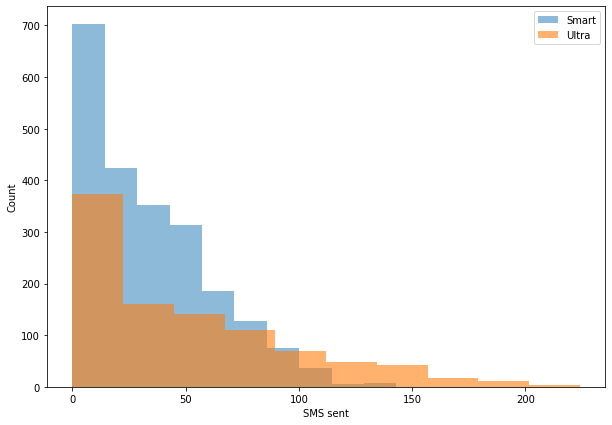

In [20]:
# гистограммы количества смс

# отобразим гистограммы на одном графике
plt.figure(figsize=(10,7))
plt.hist(smart['n_messages'], alpha=0.5, label='Smart')
plt.hist(ultra['n_messages'], alpha=0.6, label='Ultra')
plt.legend(loc='upper right')
plt.xlabel('SMS sent')
plt.ylabel('Count')
plt.show()

Гистограммы для количества отправленных смс имеют Пуассоновское распределение. Это объясняется тем, что количество смс - это дискретная величина. К тому же, события происходят за фиксированное количество времени (количество смс в месяц). Среднее и стандартное отклонение для этой величины 33.40 и 28.23 соответственно для тарифа **smart**, 49.59 и 47.98 соответственно для тарифа **ultra**. В среднем людям, подключенным к тарифу **smart** требуется 33 смс в месяц против 50 смс для людей в тарифе **ultra**.

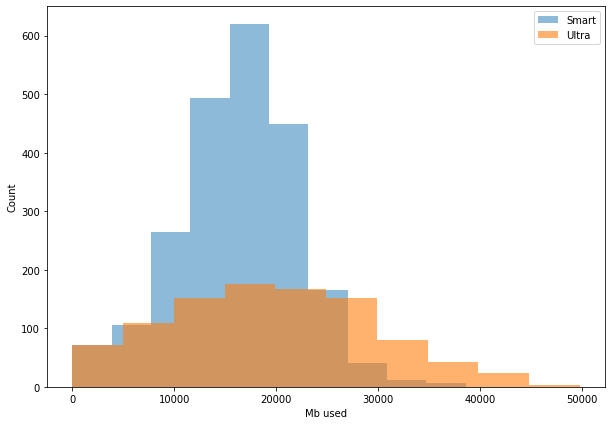

In [21]:
# гистограммы использованного интернета

# отобразим гистограммы на одном графике
plt.figure(figsize=(10,7))
plt.hist(smart['mb_used'], alpha=0.5, label='Smart')
plt.hist(ultra['mb_used'], alpha=0.6, label='Ultra')
plt.legend(loc='upper right')
plt.xlabel('Mb used')
plt.ylabel('Count')
plt.show()

Гистограммы использованных мегабайт имеют нормальное распределение со средними 16215.66	(**smart**) и 19668.49 (**ultra**), и со стандартными отклонениями 5861.74 (**smart**) и 9943.05 (**ultra**). Пользователи тарифа **ultra** в среднем используют больше интрнета, чем пользователи тарифа **smart**.

По данным, полученным выше, мы можем сделать вывод, что пользователи обоих тарифов не на полную используют возможности по минутам и смс. Пользователи тарифа **smart** немного превышают лимит по интернет-трафику, в отличии от пользователей тарифа **ultra**, которые в среднем недоиспользуют 10 ГБ.

## Проверка гипотез

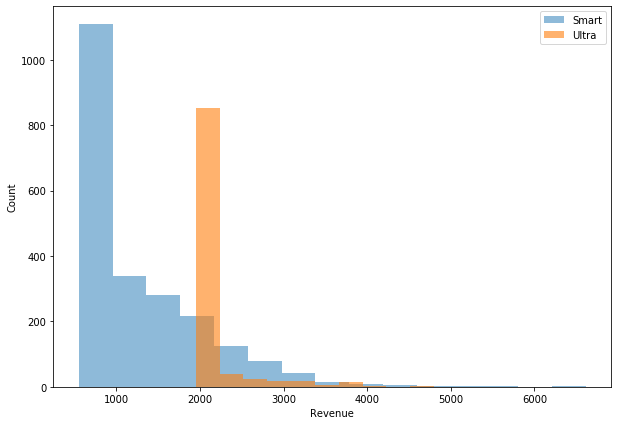

In [22]:
# гистограммы выручки по тарифам

# отобразим гистограммы на одном графике
plt.figure(figsize=(10,7))
plt.hist(smart['revenue'], bins=15, alpha=0.5, label='Smart')
plt.hist(ultra['revenue'], bins=10, alpha=0.6, label='Ultra')
plt.legend(loc='upper right')
plt.xlabel('Revenue')
plt.ylabel('Count')
plt.show()

***1) Проверим гипотезу о различии средней выручки у двух тарифов.***

- **Сформулируем нулевую и альтернативную гипотезы: H<sub>0</sub> и H<sub>a</sub>.**
    
    H<sub>0</sub>: $\mu$<sub>1</sub> = $\mu$<sub>2</sub> (средние выручки пользователей тарифов "Смарт" и "Ультра" равны)
    
    H<sub>a</sub>: $\mu$<sub>1</sub> $\neq$ $\mu$<sub>2</sub> (средние выручки пользователей тарифов "Смарт" и "Ультра" НЕ равны) - двухсторонняя альтернативная гипотеза.
    
    $\mu$<sub>1</sub> и $\mu$<sub>2</sub> - средние выручек двух генеральных совокупностей пользователей тарифов **smart** и **ultra** соответственно
    

- **Зададим уровню значимости $\alpha$ значение 0.05.**


- **Выберем статистический критерий (случайную величину) для проверки гипотезы.**


Критерий Стьюдента (t-критерий). Наши выборки довольно большие, чтобы считать, что выборочное среднее распределно нормально и мы можем апроксимировать нормальное распределение t-распределением.

- **Проведем двухвыборочный t-тест.**

Используем функцию ttest_ind() из пакета scipy.stats потому, что сравниваем средние двух генеральных совокупностей.


- **Сделаем вывод о принятии или об отклонении H<sub>0</sub> в зависимости от значения p-value.**

Если p-value > $\alpha$, то у нас нет оснований отклонить H<sub>0</sub>. В противном случае, H<sub>0</sub> отклоняется и принимается H<sub>a</sub>.

In [23]:
# выполним двухвыборочный двусторонний тест
alpha = .05
p_value = st.ttest_ind(smart['revenue'], ultra['revenue'], equal_var=False)

print(f"p-value: {p_value.pvalue}")
if p_value.pvalue < alpha:
    print('Отклоняем нулевую гипотезу и принимаем альтернативную. Выручки тарифов различаются.')
else:
    print('Отклоняем альтернативную гипотезу и принимаем нулевую. Выручки тарифов НЕ различаются.')

p-value: 4.19096840440574e-273
Отклоняем нулевую гипотезу и принимаем альтернативную. Выручки тарифов различаются.


In [24]:
smart_rev_mean = round(smart['revenue'].mean(), 2)
ultra_rev_mean = round(ultra['revenue'].mean(), 2)
print(f'Выборочное среднее выручки пользователей тарифа "Смарт": {smart_rev_mean}')
print(f'Выборочное среднее выручки пользователей тарифа "Ультра": {ultra_rev_mean}')

Выборочное среднее выручки пользователей тарифа "Смарт": 1257.28
Выборочное среднее выручки пользователей тарифа "Ультра": 2071.38


При проведении теста задали параметр **equal_var=False**, так как сравниваемые выборки отличаются размером, а также есть различия в поведении у пользователей тарифа **ultra**. Получили значение p-value намного меньше уровня значимости. Это означает, что вероятность получить такие или еще большие значения статистического критерия, при условии, что нулевая гипотеза верна, почти равна нулю.

***2) Проверим гипотезу о различии средней выручки у пользователей из Москвы и других регионов.***

- **Сформулируем нулевую и альтернативную гипотезы: H<sub>0</sub> и H<sub>a</sub>.**
    
    H<sub>0</sub>: $\mu$<sub>1</sub> = $\mu$<sub>2</sub> (средняя выручка пользователей из Москвы равна выручке пользователей из других регионов)
    
    H<sub>a</sub>: $\mu$<sub>1</sub> $\neq$ $\mu$<sub>2</sub> (средняя выручка пользователей из Москвы НЕ равна выручке пользователей из других регионов) - двухсторонняя альтернативная гипотеза.
    
    $\mu$<sub>1</sub> и $\mu$<sub>2</sub> - средние выручек двух генеральных совокупностей пользователей из Москвы и других регионов соответственно
    

- **Зададим уровню значимости $\alpha$ значение 0.05.**


- **Выберем статистический критерий (случайную величину) для проверки гипотезы.**


Критерий Стьюдента (t-критерий). Наши выборки довольно большие, чтобы считать, что выборочное среднее распределно нормально и мы можем апроксимировать нормальное распределение t-распределением.

- **Проведем двухвыборочный t-тест.**

Используем функцию ttest_ind() из пакета scipy.stats, потому, что сравниваем средние двух генеральных совокупностей.


- **Сделаем вывод о принятии или об отклонении H<sub>0</sub> в зависимости от значения p-value.**

Если p-value > $\alpha$, то у нас нет оснований отклонить H<sub>0</sub>. В противном случае, H<sub>0</sub> отклоняется и принимается H<sub>a</sub>.

In [25]:
# добавим к общей таблице города пользователей
users_activity_month = users_activity_month.join(users['city'], on='user_id')

# создадим колонку с категорией города (Москва, Другой)
def city_assigner(row):
    if row['city'] == 'Москва':
        return 'Москва'
    else:
        return 'Другой'
    
users_activity_month['city_cat'] = users_activity_month.apply(city_assigner, axis=1)
users_activity_month

,user_id,month,mb_used,n_calls,calls_duration,n_messages,tariff,revenue,city,city_cat
0,1000,5,2253.49,22.0,149.0,22.0,ultra,1950.0,Краснодар,Другой
1,1000,6,23233.77,43.0,159.0,60.0,ultra,1950.0,Краснодар,Другой
2,1000,7,14003.64,47.0,319.0,75.0,ultra,1950.0,Краснодар,Другой
3,1000,8,14055.93,52.0,391.0,81.0,ultra,1950.0,Краснодар,Другой
4,1000,9,14568.91,58.0,439.0,57.0,ultra,1950.0,Краснодар,Другой
...,...,...,...,...,...,...,...,...,...,...
3198,1498,10,20579.36,41.0,230.0,42.0,smart,1750.0,Владикавказ,Другой
3199,1499,9,1845.75,9.0,64.0,11.0,smart,550.0,Пермь,Другой
3200,1499,10,17788.51,68.0,429.0,48.0,smart,1150.0,Пермь,Другой
3201,1499,11,17963.31,74.0,574.0,59.0,smart,1399.0,Пермь,Другой


In [26]:
#сформируем выборки (Москва vs Другие)

from_moscow = users_activity_month.query('city_cat == "Москва"')
from_another = users_activity_month.query('city_cat == "Другой"')

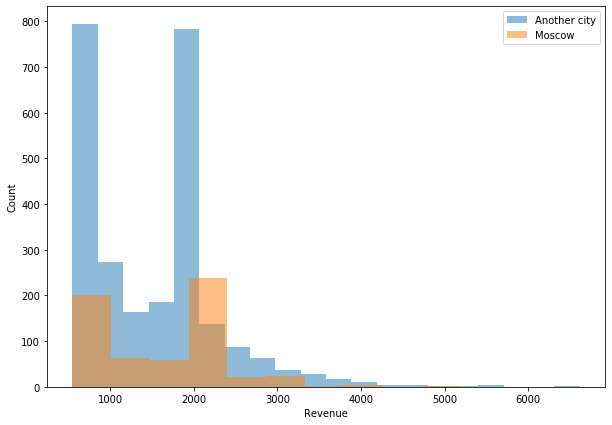

In [27]:
# гистограммы выручки по городам

# отобразим гистограммы на одном графике
plt.figure(figsize=(10,7))
plt.hist(from_another['revenue'], alpha=0.5, bins=20, label='Another city')
plt.hist(from_moscow['revenue'], bins=10, alpha=0.5, label='Moscow')
plt.legend(loc='upper right')
plt.xlabel('Revenue')
plt.ylabel('Count')
plt.show()

In [28]:
# выполним двухвыборочный двусторонний тест
alpha = .05
p_value = st.ttest_ind(from_another['revenue'], from_moscow['revenue'], equal_var=False)

print(f"p-value: {p_value.pvalue}")
if p_value.pvalue < alpha:
    print('Отклоняем нулевую гипотезу и принимаем альтернативную. Выручки по городам различаются.')
else:
    print('Отклоняем альтернативную гипотезу и принимаем нулевую. Выручки по городам НЕ различаются.')

p-value: 0.44160456365323286
Отклоняем альтернативную гипотезу и принимаем нулевую. Выручки по городам НЕ различаются.


## Общий вывод

В данном проекте мы работали с данными 500 пользователей телеком-оператора "Мегалайн". Целью проекта было установить лучший из двух тарифов.

Сначала изучили данные из разный файлов, привели переменные к нужным типам. Ошибок и аномалий в данных обнаружено не было. Далее, пересчитали средние показатели продолжительности звонков, количества смс, интрнет-траффика на пользователя в конкретный месяц. Пересчитанные данные объединили в общую таблицу методом merge(). После этого, расчитали помесячную выручку на клиента, исходя из правил оператора: секунды округляются до минут, а мегабайты до гигабайт. Проверили распределения основных величин и описали их.

В ходе проекта было проверено две гипотезы:
- средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются. 

**Вывод:** между выручками тарифов есть статистически значимые различия. Тариф "Ультра" приносит в среднем больше денег. Это можно описать тем фактом, что пользователи обоих тарифов в среднем недоиспользуют их лимиты (звонки, смс, иногда интернет). Они платят только абонентскую плату, а она больше в тарифе "Ультра".

- средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

**Вывод:** между выручкой пользователей из Москвы и других городов **НЕТ** статистически значимых различий.

Исходя из результатов исследования, можно сделать вывод, что тариф "Ультра" лучше по выручке и большую долю рекламного бюджет лучше пустить на него. При этом, рекламный бюджет не должен зависеть от города: нет смысла пускать больший рекламный бюджет на Москву, так как выручка там не отличается от выручки в других регионах.